# Testing of the image processing for the image -> dxf pipeline

Input image -> Clean -> Standardise -> Threshold -> Extract lines 

Author: Mark Peacock


## Imports

In [ ]:
from pathlib import Path
from pathlib import PosixPath
import pyvips
from rich import pretty, print
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageShow
import numpy as np
import cv2 as cv
import math
from skimage.morphology import skeletonize

pretty.install()

## Load a photo or handrawn image

### Using PyVips with the aim to keep a high quality image



In [2]:
image_directory = Path("sample_data")
image_extensions = ['*.jpg', '*.JPG', '*.jpeg', '*.png', '*.bmp', '*.tiff']
image_files = []
for ext in image_extensions:
    image_files.extend(image_directory.glob(ext))
print(image_files)
print(type(image_files[0]))

[PosixPath('sample_data/IMG_5503.JPG')]

<class 'pathlib.PosixPath'>

In [3]:
# Creating pyvips images from the directory of sample images: sample_data
# Store in a list: pyvips_images

pyvips_images = []
for im in image_files:
    image = pyvips.Image.new_from_file(im)
    pyvips_images.append(image)
    

### Sample image

<class 'pyvips.vimage.Image'>

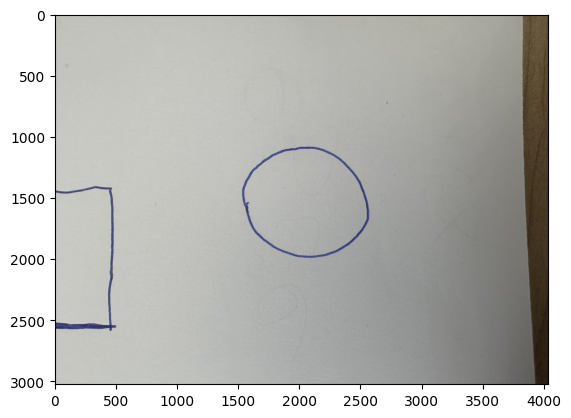

In [4]:
plt.imshow(pyvips_images[0])
print(type(pyvips_images[0]))

### Process the images

- To greyscale
- threshold

1.0

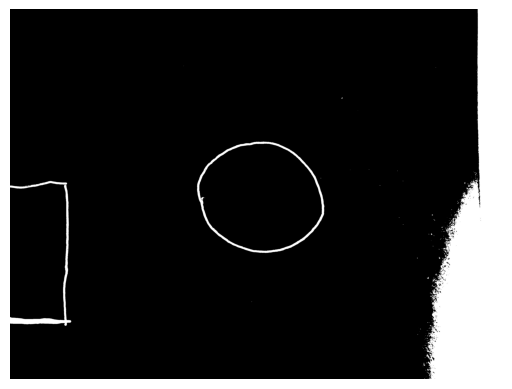

<class 'pyvips.vimage.Image'>

Processed: 4032x3024, 1 bands

Format: uchar, Interpretation: b-w

In [5]:
processed_images = []

for image in pyvips_images:
    image = image.median(3)
    if image.hasalpha():
        image = image.flatten(background=[255])
    print(image.get_scale())
    image = image.colourspace('b-w')
    image = image < 127
    if image.bands > 1:
        image = image.extract_band(0)
    image = image.copy(interpretation='b-w')
    processed_images.append(image)

# Look at sample image
plt.imshow(processed_images[0], cmap="gray")
plt.axis('off')
plt.show()
processed_images[0].write_to_file("processed_example_image.jpg", strip=True)
print(type(processed_images[0]))
print(f"Processed: {processed_images[0].width}x{processed_images[0].height}, {processed_images[0].bands} bands")
print(f"Format: {processed_images[0].format}, Interpretation: {processed_images[0].interpretation}")


## Edge Detection and line extraction

- Canny edge detection
- Hough line / circles etc
- OR PoTrace but need to figure out installation

## Experimenting with Manual canny implementation and openCv instead to see results


### Load the image with opencv

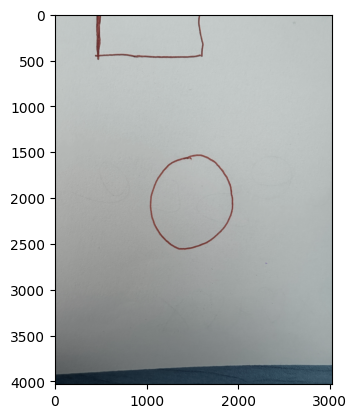

In [6]:
cv_sample_image = cv.imread(image_files[0])
plt.imshow(cv_sample_image)
plt.show()


### Image processing and canny edge with opencv

<class 'numpy.ndarray'>

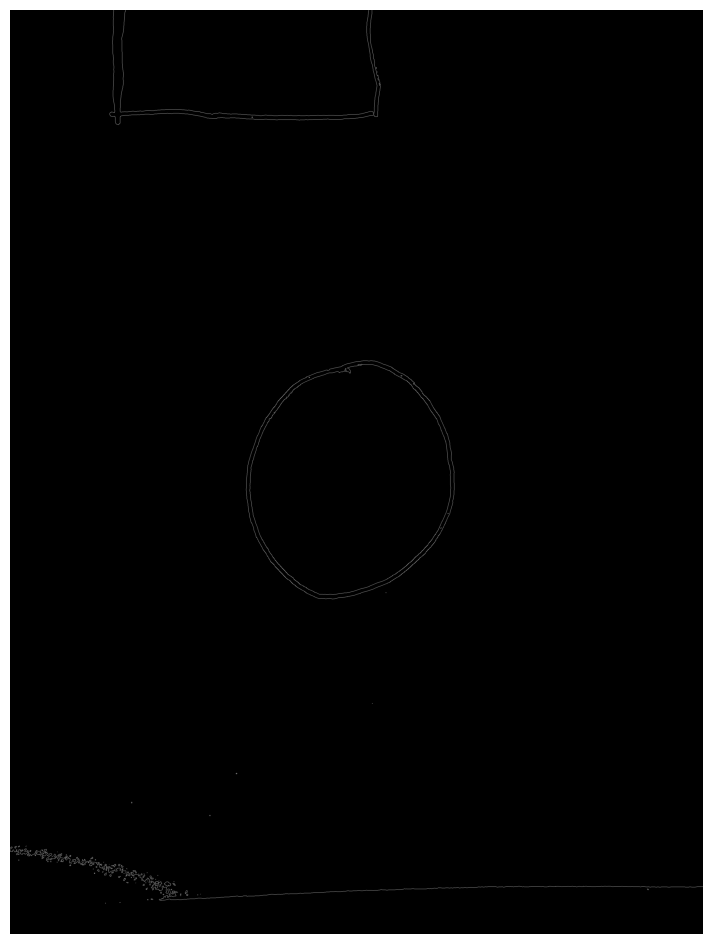

In [ ]:
# COnvert to greyscale
img = cv.cvtColor(cv_sample_image, cv.COLOR_BGR2GRAY)

# noise reduction
img = cv.GaussianBlur(img, (5,5), 1.4)

ret, img_thresholded = cv.threshold(img, 110, 255, cv.THRESH_BINARY)
print(type(img_thresholded))

canny_edges = cv.Canny(img_thresholded, 50, 150)

plt.figure(figsize=(12, 12))
plt.imshow(canny_edges, cmap="gray")
plt.axis('off')
plt.show()


<class 'numpy.ndarray'>

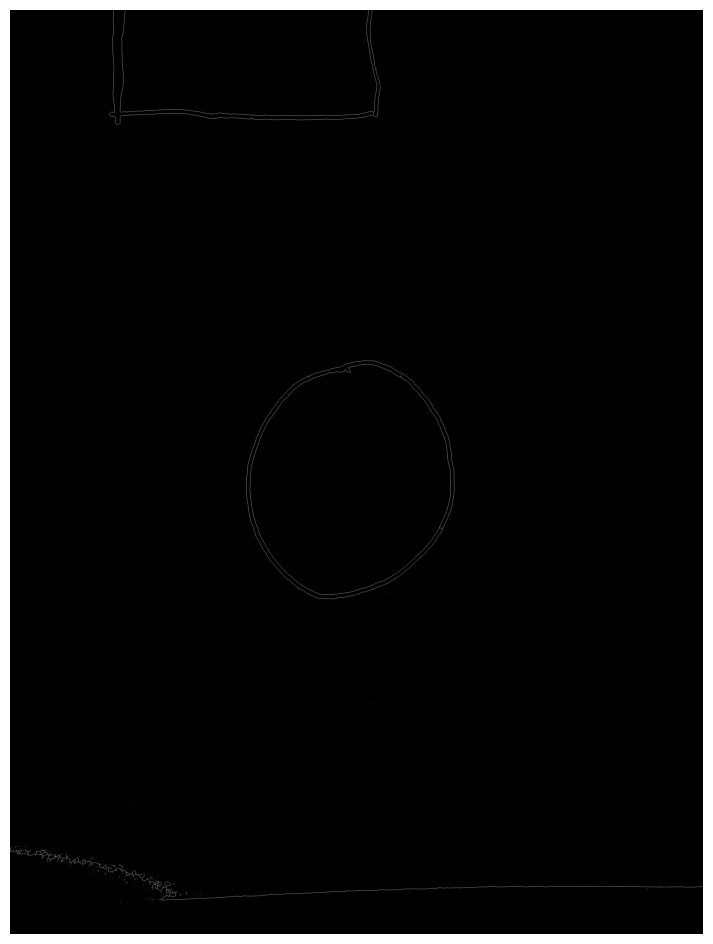

In [8]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7,7))
dilated = cv.dilate(canny_edges, kernel, iterations=1)
filled_strokes = cv.erode(dilated, kernel, iterations=1)

img_skeletonised = skeletonize(filled_strokes)
print(type(img_thresholded))
skeleton_uint8 = (img_skeletonised * 255).astype(np.uint8)

plt.figure(figsize=(12, 12))
plt.imshow(skeleton_uint8, cmap="gray")
plt.axis('off')
plt.show()



### Manual implementation

In [9]:

# Calculate gradients
gx = cv.Sobel(np.float32(img), cv.CV_64F, 1, 0, 3)
gy = cv.Sobel(np.float32(img), cv.CV_64F, 0, 1, 3)

mag, ang = cv.cartToPolar(gx, gy, angleInDegrees=True)

#setting min and max thresholds
mag_max = np.max(mag)
weak_th = mag_max * 0.1
strong_th = mag_max * 0.5

height, width = img.shape

for i_x in range(width):
    for i_y in range(height):
        grad_ang = ang[i_y, i_x]
        grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
        # selecting the neighbours of the target pixel
            # according to the gradient direction
            # In the x axis direction
        if grad_ang<= 22.5:
            neighb_1_x, neighb_1_y = i_x-1, i_y
            neighb_2_x, neighb_2_y = i_x + 1, i_y
        
        # top right (diagonal-1) direction
        elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
            neighb_1_x, neighb_1_y = i_x-1, i_y-1
            neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
        
        # In y-axis direction
        elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
            neighb_1_x, neighb_1_y = i_x, i_y-1
            neighb_2_x, neighb_2_y = i_x, i_y + 1
        
        # top left (diagonal-2) direction
        elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
            neighb_1_x, neighb_1_y = i_x-1, i_y + 1
            neighb_2_x, neighb_2_y = i_x + 1, i_y-1
        
        # Now it restarts the cycle
        elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
            neighb_1_x, neighb_1_y = i_x-1, i_y
            neighb_2_x, neighb_2_y = i_x + 1, i_y
            
        # Non-maximum suppression step
        if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
            if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
                mag[i_y, i_x]= 0
                continue

        if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
            if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
                mag[i_y, i_x]= 0

weak_ids = np.zeros_like(img)
strong_ids = np.zeros_like(img)              
ids = np.zeros_like(img)
    
# double thresholding step
for i_x in range(width):
    for i_y in range(height):
        
        grad_mag = mag[i_y, i_x]
        
        if grad_mag<weak_th:
            mag[i_y, i_x]= 0
        elif strong_th>grad_mag>= weak_th:
            ids[i_y, i_x]= 1
        else:
            ids[i_y, i_x]= 2
            
edges = np.zeros_like(mag, dtype=np.uint8)

for i_x in range(width):
    for i_y in range(height):
        if ids[i_y, i_x] == 2:  # strong
            edges[i_y, i_x] = 255
        elif ids[i_y, i_x] == 1:  # weak
            # Optional: Include edge connectivity logic here (e.g., hysteresis)
            edges[i_y, i_x] = 0  # or 255 if connected to strong
        else:
            edges[i_y, i_x] = 0
     


### From the pyvips processed:

In [10]:
threshold_value = 30

im = np.frombuffer(processed_images[0].write_to_memory(), dtype=np.uint8)
im = im.reshape(processed_images[0].height, processed_images[0].width, processed_images[0].bands)
detected_edges = cv.Canny(im, 100, threshold_value*3,None, 3)

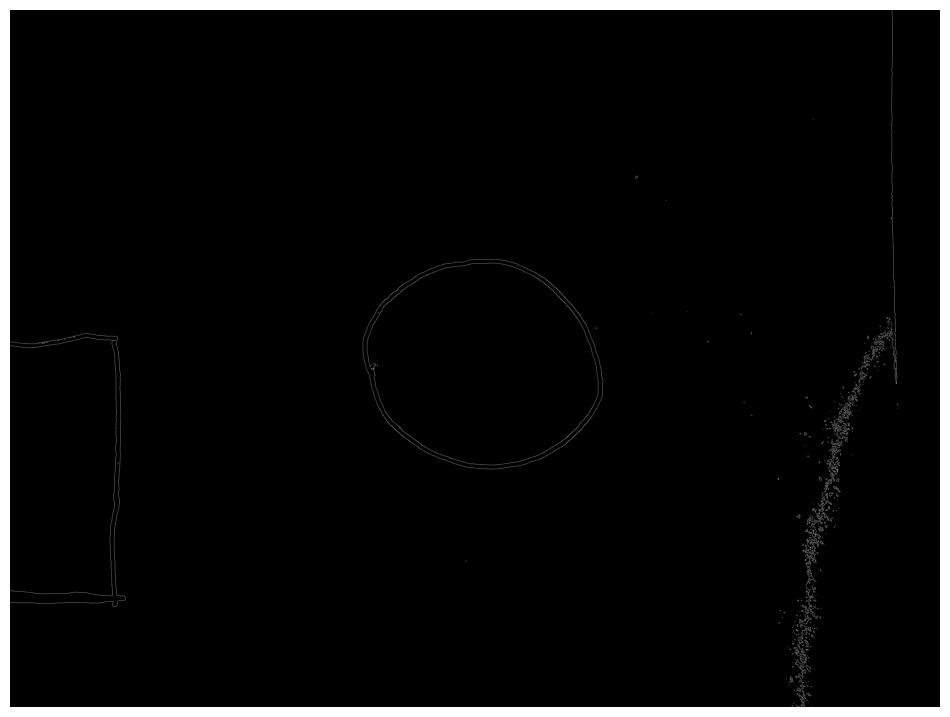

In [11]:
plt.figure(figsize=(12, 12))
plt.imshow(detected_edges, cmap="gray")
plt.axis('off')
plt.show()

## Probabalistic hough line transform

In [12]:
# for the image processed using pyvips 
cdst = cv.cvtColor(detected_edges, cv.COLOR_GRAY2BGR)
lines = cv.HoughLinesP(detected_edges, 1, np.pi / 180, 50, None, 50, maxLineGap=10)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv.line(cdst, (x1, y1), (x2, y2), (0, 255, 0), 3, cv.LINE_AA)
        
        
# for the image processed only using cv2
print(type(edges))
print(type(detected_edges))

cdst_cv_manual = cv.cvtColor(edges, cv.COLOR_GRAY2BGR)
lines_cv_manual = cv.HoughLinesP(edges, 1, np.pi / 180, 50, None, 50, maxLineGap=10)

if lines is not None:
    for line in lines_cv_manual:
        x1, y1, x2, y2 = line[0]
        cv.line(cdst_cv_manual, (x1, y1), (x2, y2), (0, 255, 0), 3, cv.LINE_AA)
        
# manual canny edge implentaton
cdst_cv = cv.cvtColor(canny_edges, cv.COLOR_GRAY2BGR)
lines_cv = cv.HoughLinesP(canny_edges, 1, np.pi / 180, 50, None, 50, maxLineGap=10)

if lines is not None:
    for line in lines_cv:
        x1, y1, x2, y2 = line[0]
        cv.line(cdst_cv, (x1, y1), (x2, y2), (0, 255, 0), 3, cv.LINE_AA)

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

### Using Pyvips for the preprocessing

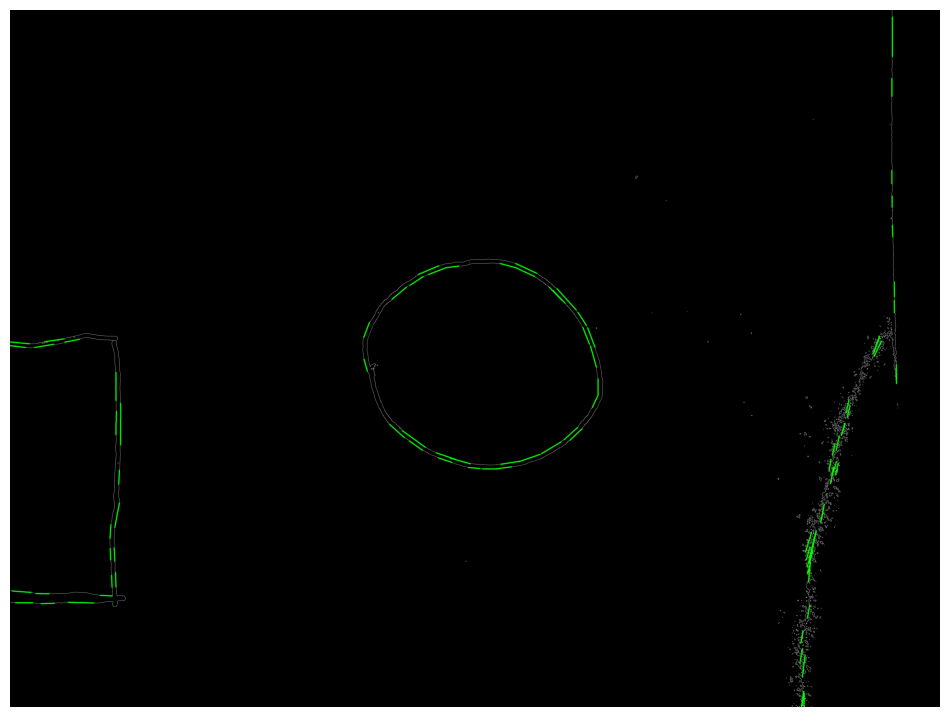

In [13]:
plt.figure(figsize=(12, 12))

plt.imshow(detected_edges, cmap='gray')
plt.imshow(cdst)
plt.axis('off')
plt.show()

In [14]:
print(lines[1])

[[3825  206 3825   34]]

### Using just openCV

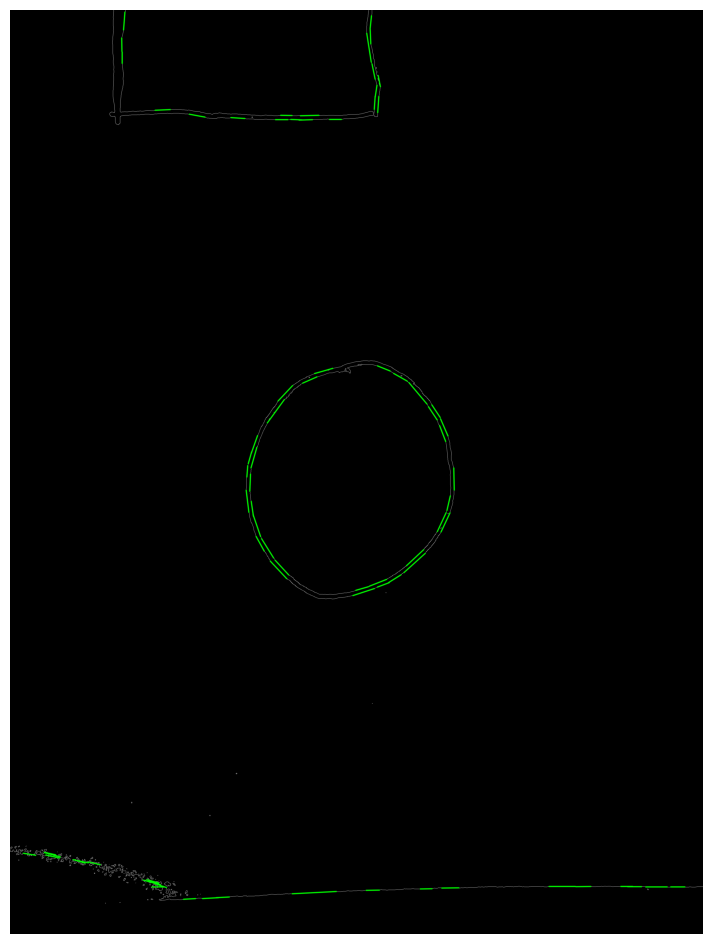

In [28]:
plt.close('all')
plt.figure(figsize=(12, 12))
plt.imshow(edges, cmap='gray')
plt.imshow(cdst_cv)
plt.axis('off')
plt.show()

### Manual canny edge implementation

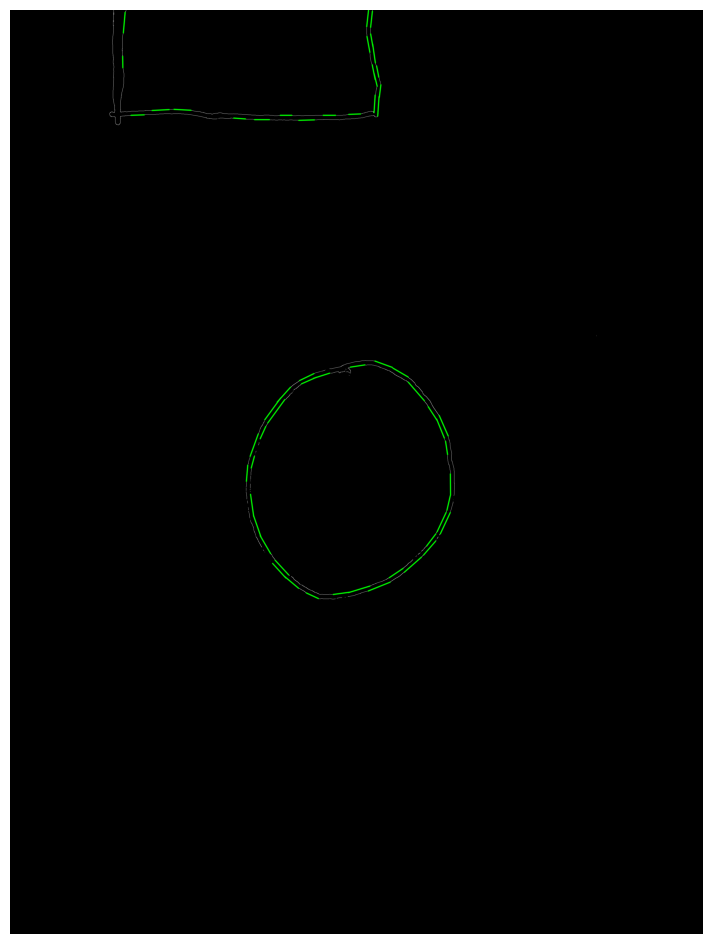

In [27]:
plt.close('all')
plt.figure(figsize=(12, 12))
plt.imshow(edges, cmap='gray')
plt.imshow(cdst_cv_manual)
plt.axis('off')
plt.show()

## Results

### Manual canny

The line detection was not very good, almost looks like it lost bottom half

### OpenCv canny

good as it doesnt show the image inperfections as lines in the lower corners and looks similar to the pyvips processed shapes

### OpenCv canny with pyvips processing

This seems to be the best for the drawn shape but shows some weird inperfections in the lower corners

## Hough line transform

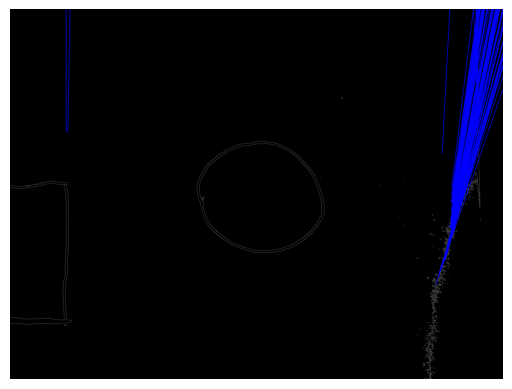

In [17]:
cdst = cv.cvtColor(detected_edges, cv.COLOR_GRAY2BGR)
lines = cv.HoughLines(detected_edges, 1, np.pi / 180, 150, None, 0, 0)
    
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv.line(cdst, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
plt.close('all')
plt.imshow(detected_edges, cmap='gray')
plt.imshow(cdst)
plt.axis('off')
plt.show()

In [22]:
plt.close()

### Transform results

- Probabilistic actually works 
- Standard hough line does not work for this


### Next steps:

- Bridge gaps in lines
- convert several sketch lines into one smooth line
- Contour lines for corners


## Using contours to extract the lines:

In [30]:
# img_thresholded is the cv thresholded image
print(img_skeletonised)
print(skeleton_uint8)
contours, _ = cv.findContours(skeleton_uint8, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)    

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

In [31]:
plt.close()

<class 'numpy.ndarray'>

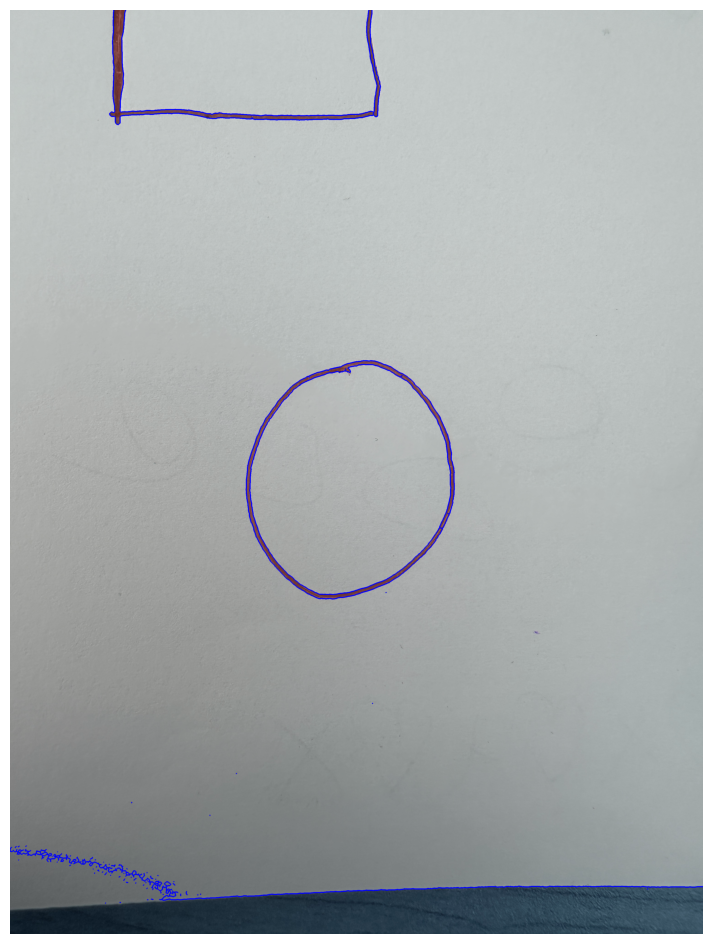

In [32]:
con = cv.drawContours(cv_sample_image, contours, -1, (0,0,255), 4)
print(type(con))
plt.close('all')
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.imshow(con, cmap="gray")

plt.show()

In [33]:
print(len(contours))
print(contours[6].shape)

85

(4, 1, 2)

In [29]:
contours


(
    array([[[ 417, 3896]],

       [[ 416, 3897]]], dtype=int32),
    array([[[ 479, 3894]],

       [[ 482, 3894]]], dtype=int32),
    array([[[ 599, 3882]],

       [[ 602, 3882]]], dtype=int32),
    array([[[ 617, 3879]],

       [[ 616, 3880]],

       [[ 617, 3879]],

       [[ 618, 3879]],

       [[ 619, 3880]],

       [[ 621, 3880]],

       [[ 622, 3881]],

       [[ 624, 3881]],

       [[ 622, 3881]],

       [[ 621, 3880]],

       [[ 619, 3880]],

       [[ 618, 3879]]], dtype=int32),
    array([[[ 818, 3861]],

       [[ 820, 3861]]], dtype=int32),
    array([[[ 667, 3859]],

       [[ 669, 3859]]], dtype=int32),
    array([[[ 832, 3857]],

       [[ 831, 3858]],

       [[ 831, 3859]],

       [[ 831, 3858]]], dtype=int32),
    array([[[ 745, 3857]],

       [[ 744, 3858]],

       [[ 744, 3864]],

       [[ 745, 3865]],

       [[ 744, 3864]],

       [[ 744, 3858]]], dtype=int32),
    array([[[ 657, 3847]],

       [[ 657, 3848]],

       [[ 659, 3850]],

       [[